# <font color=blue>**Energy Consumption Prediction**</font>

- RNN
- LSTM
- GRU

<font color=blue>**Dataset**</font>: The dataset contains power consumption data across different regions around the United States recorded on an hourly basis. 

For detailed information about the dataset, please refer to the [dataset documentation](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/discussion?sort=hotness).

<font color=blue>**Objective**</font>: The goal of this implementation is to use RNN models that can accurately predict the energy usage in the next hour given historical usage data.

## <font color=blue>**Importing libraries**</font>

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Define data root directory
data_dir = "./data/Power_consumption/"
print(os.listdir(data_dir))
print('\n Total number of files:', len(os.listdir(data_dir)))

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'PJM_Load_hourly.csv']

 Total number of files: 12


In [3]:
pd.read_csv(data_dir + 'AEP_hourly.csv').head()  # American Electric Power (electric utility company)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


## <font color=blue>**Data Preprocessing**</font>

In [4]:
from tqdm import tqdm 
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in tqdm(os.listdir(data_dir)):

    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(data_dir + file, parse_dates=[0])   #parses the first column (DateTime) into datetime objects.

    #Extract Time Features
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc

    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)

    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)

    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

100%|██████████| 12/12 [00:38<00:00,  3.22s/it]


In [5]:
df.head(5)

,PJM_Load_MW,hour,dayofweek,month,dayofyear
6574,22259.0,1,2,4,91
6575,21244.0,2,2,4,91
6576,20651.0,3,2,4,91
6577,20421.0,4,2,4,91
6578,20713.0,5,2,4,91


In [6]:
print(train_x.shape)
print('Total 980,185 sequences of training data')


(980185, 90, 5)
Total 980,185 sequences of training data


In [7]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [8]:
len(train_loader)

957

In [9]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print('GPU is available')
else:
    device = torch.device("cpu")
    print('GPU is not available')



GPU is available


## <font color=blue>**Structure of RNNs**</font>

- Models have the same structure, with the only difference being the recurrent layer (GRU/LSTM) and the initializing of the hidden state.

- The hidden state for the LSTM is a tuple containing both the cell state and the hidden state, whereas the GRU & RNN only have a single hidden state.


In [10]:
## RNN
class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(RNNNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x, h):
        # Passing the input and hidden state into the RNN layer
        out, h = self.rnn(x, h)

        # Pass the output of the RNN through ReLU and the fully connected layer
        out = self.fc(self.relu(out[:,-1]))  # Getting the output at the last time step

        return out, h

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        # Return only a single tensor for RNN hidden state
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

## GRU
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

## LSTM
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

## <font color='blue'>**Model Training**</font>

- For accuracy measure, we'll use Symmetric Mean Absolute Percentage Error (sMAPE) to evaluate the models performance. 
    -  Used to measure prediction accuracy in terms of percentage error.
    - sMAPE is the sum of the absolute difference between the predicted and actual values divided by the average of the predicted and actual value, therefore giving a percentage measuring the amount of error.

$$
\textcolor{blue}{\text{sMAPE}} = \frac{1}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{\frac{|y_i| + |\hat{y}_i|}{2}} \times 100
$$



In [11]:
def train(train_loader, hidden_dim=256, EPOCHS=5, model_type="LSTM"):

    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    model = None
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    elif model_type == "LSTM":
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    elif model_type == "RNN":
        model = RNNNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)

    # Defining loss function and optimizer
    learn_rate = 0.001
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.time()
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:

            counter += 1

            h = model.init_hidden(x.size(0))

            model.zero_grad()   # Ensure that gradients from the previous iteration are cleared out.

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()     # Compute gradients for the current batch.
            optimizer.step()    # Update model parameters based on the computed gradients
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    
    outputs = []
    targets = []
    start_time = time.time()

    with torch.no_grad():
        for i in test_x.keys():

            inp = torch.from_numpy(np.array(test_x[i]))
            labs = torch.from_numpy(np.array(test_y[i]))

            batch_size = 32

            test_data = TensorDataset(inp, labs)
            test_loader = DataLoader(test_data, batch_size=batch_size, drop_last=True)
            
            for test_dt, test_lbl in test_loader:

                h_test = model.init_hidden(test_dt.size(0))
                out, h = model(test_dt.to(device).float(), h_test)
                outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
                targets.append(label_scalers[i].inverse_transform(test_lbl.numpy()).reshape(-1))
                # Clear GPU cache
                torch.cuda.empty_cache()

        print("Evaluation Time: {}".format(str(time.time()-start_time)))
        
        
        sMAPE = 0
        for i in range(len(outputs)):
            sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
        print("sMAPE: {}%".format(sMAPE*100))
        
    return outputs, targets, sMAPE

In [12]:
rnn_model = train(train_loader, model_type="RNN")

Starting Training of RNN model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.00568614430638263
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.0032317769518704154
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.002332301119992432
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.0018491772353081614
Epoch 1/5 Done, Total Loss: 0.0015956396572911029
Time Elapsed for Epoch: 65.58775544166565 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0002751652364531765
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.0002510745314793894
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.00024215698921276876
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.00022886427284902312
Epoch 2/5 Done, Total Loss: 0.00022203519444607584
Time Elapsed for Epoch: 66.10417890548706 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.0001761949691717746
Epoch 3......Step: 400/957....... Average Loss fo

In [13]:
rnn_outputs, targets, rnn_sMAPE = evaluate(rnn_model, test_x, test_y, label_scalers)

Evaluation Time: 7.848086595535278
sMAPE: 0.24330783421976734%


In [14]:

gru_model = train(train_loader, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.007096324677986559
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.003919406647037249
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.00276902226357682
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.002165872410078009
Epoch 1/5 Done, Total Loss: 0.0018588243260651937
Time Elapsed for Epoch: 120.26423335075378 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.00023316255646932404
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.0002283831502427347
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.00021977838301002824
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.00021144562306290026
Epoch 2/5 Done, Total Loss: 0.00020604427774215863
Time Elapsed for Epoch: 121.00481271743774 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.00017034770447935444
Epoch 3......Step: 400/957....... Average Loss 

In [15]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 19.347461938858032
sMAPE: 0.2424652338691997%


In [16]:
lstm_model = train(train_loader, model_type="LSTM")

Starting Training of LSTM model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.014760091104544699
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.008104325222520857
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.0056619704897942335
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.004374319244525395
Epoch 1/5 Done, Total Loss: 0.0037227660291227283
Time Elapsed for Epoch: 157.54041171073914 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0003332205065817107
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.0003093023836845532
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.00029269972670590503
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.0002788043903819926
Epoch 2/5 Done, Total Loss: 0.000268889921427828
Time Elapsed for Epoch: 157.04552745819092 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.00021299572479620111
Epoch 3......Step: 400/957....... Average Loss f

In [17]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 21.303335905075073
sMAPE: 0.25216571759466067%


### <font color='blue'>Training time</font>

In [44]:
print('Total Training time by RNN:  333.50 seconds')
print('Total Training time by GRU:  607.24 seconds')
print('Total Training time by LSTM: 784.34 seconds')

Total Training time by RNN:  333.50 seconds
Total Training time by GRU:  607.24 seconds
Total Training time by LSTM: 784.34 seconds


As we can see from the training time of both models, the GRU model is efficient in terms of speed. The GRU finished 5 training epochs 160 seconds faster than the LSTM model.

### <font color='blue'>Visualization</font>

Lastly, let's do some visualisations on random sets of our predicted output vs the actual consumption data.

In [32]:
total_size = sum(len(v) for v in test_x.values())
print(f"Total number of values: {total_size}")


Total number of values: 108902


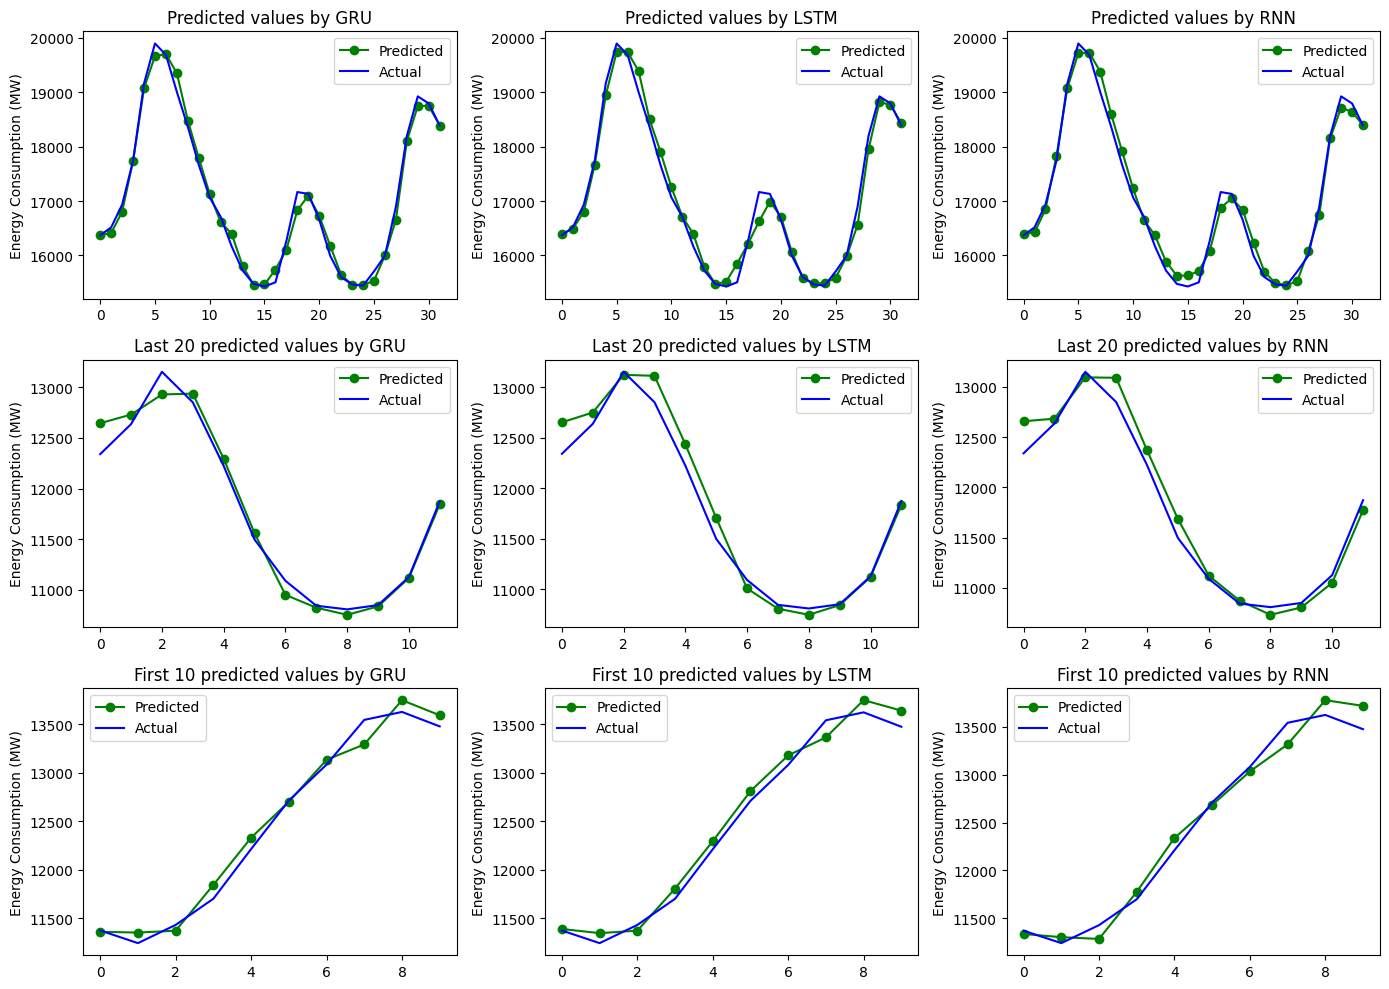

In [43]:
plt.figure(figsize=(14,10))
plt.subplot(3,3,1)
plt.plot(gru_outputs[0], "-o", color="g", label="Predicted")
plt.plot(targets[0], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('Predicted values by GRU')
plt.tight_layout()
plt.legend()

plt.subplot(3,3,2)
plt.plot(lstm_outputs[0], "-o", color="g", label="Predicted")
plt.plot(targets[0], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('Predicted values by LSTM')
plt.legend()
plt.tight_layout()

plt.subplot(3,3,3)
plt.plot(rnn_outputs[0], "-o", color="g", label="Predicted")
plt.plot(targets[0], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('Predicted values by RNN')
plt.legend()
plt.tight_layout()


plt.subplot(3,3,4)
plt.plot(gru_outputs[8][:-20], "-o", color="g", label="Predicted")
plt.plot(targets[8][:-20], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('Last 20 predicted values by GRU')
plt.legend()
plt.tight_layout()

plt.subplot(3,3,5)
plt.plot(lstm_outputs[8][:-20], "-o", color="g", label="Predicted")
plt.plot(targets[8][:-20], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('Last 20 predicted values by LSTM')
plt.legend()
plt.tight_layout()


plt.subplot(3,3,6)
plt.plot(rnn_outputs[8][:-20], "-o", color="g", label="Predicted")
plt.plot(targets[8][:-20], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('Last 20 predicted values by RNN')
plt.legend()
plt.tight_layout()

plt.subplot(3,3,7)
plt.plot(gru_outputs[12][:10], "-o", color="g", label="Predicted")
plt.plot(targets[12][:10], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('First 10 predicted values by GRU')
plt.legend()
plt.tight_layout()

plt.subplot(3,3,8)
plt.plot(lstm_outputs[12][:10], "-o", color="g", label="Predicted")
plt.plot(targets[12][:10], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('First 10 predicted values by LSTM')
plt.legend()
plt.tight_layout()

plt.subplot(3,3,9)
plt.plot(rnn_outputs[12][:10], "-o", color="g", label="Predicted")
plt.plot(targets[12][:10], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.title('First 10 predicted values by RNN')
plt.legend()
plt.tight_layout()
plt.show()